In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/xfs/home/tensor_zy/guoxuan/Task3/ChatGLM/inferencing")

In [2]:
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score, auc
from tqdm import tqdm
import pandas as pd
import json, torch

from cover_alpaca2jsonl import format_example

In [3]:
model_path = "THUDM/chatglm2-6b"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=True, device = "cuda")
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=False, device_map = "auto")

from peft import PeftModel
peft_path = "/xfs/home/tensor_zy/guoxuan/Task3/ChatGLM_general_data/finetuned_model/"
model = PeftModel.from_pretrained(model, peft_path)

# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, device_map = "auto")
model = torch.compile(model)
model = model.eval()

[2023-07-30 22:41:43,135] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
model

OptimizedModule(
  (_orig_mod): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): ChatGLMForConditionalGeneration(
        (transformer): ChatGLMModel(
          (embedding): Embedding(
            (word_embeddings): Embedding(65024, 4096)
          )
          (rotary_pos_emb): RotaryEmbedding()
          (encoder): GLMTransformer(
            (layers): ModuleList(
              (0-27): 28 x GLMBlock(
                (input_layernorm): RMSNorm()
                (self_attention): SelfAttention(
                  (query_key_value): Linear(
                    in_features=4096, out_features=4608, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=4096, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_feat

### Load Dataset

In [10]:
from datasets import load_dataset
import datasets

dataset = load_dataset("winogrande",'winogrande_xl')
dataset = dataset['validation']
dataset

Found cached dataset winogrande (/xfs/home/tensor_zy/.cache/huggingface/datasets/winogrande/winogrande_xl/1.1.0/a826c3d3506aefe0e9e9390dcb53271070536586bab95849876b2c1743df56e2)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['sentence', 'option1', 'option2', 'answer'],
    num_rows: 1267
})

In [11]:
dataset = dataset.to_pandas()
dataset.head(2)

,sentence,option1,option2,answer
0,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,2
1,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,1


In [12]:
dataset['instruction'] = 'Please choose the best answer from the two options.'
dataset['input'] = dataset.apply(lambda x:x['sentence'] + " {" + x['option1']+"/"+x["option2"]+"}.",axis = 1)
dataset['output'] = dataset.apply(lambda x:x['option1'] if x['answer'] == 1 else x['option2'], axis = 1)
dataset.head(2)

,sentence,option1,option2,answer,instruction,input,output
0,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,2,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria
1,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,1,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria


In [13]:
dataset[["context","target"]] = dataset.apply(format_example, axis = 1, result_type="expand")
dataset.head(2)

,sentence,option1,option2,answer,instruction,input,output,context,target
0,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,2,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria,Instruction: Please choose the best answer fro...,Maria
1,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,1,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria,Instruction: Please choose the best answer fro...,Maria


In [14]:
context = dataset['context'].tolist()
len(context)

1267

In [15]:
batch_size = 64

total_steps = dataset.shape[0]//batch_size
total_steps

19

In [16]:
res_list = []
res_sentences_list = []
out_text_list = []

for i in tqdm(range(total_steps+1)):
    tmp_context = context[i* batch_size:(i+1)* batch_size]
    tokens = tokenizer(tmp_context, return_tensors='pt', padding=True, max_length=512)
    for k in tokens.keys():
        tokens[k] = tokens[k].cuda()
    
    res = model.generate(**tokens, max_length=512)
    res_sentences = [tokenizer.decode(i) for i in res]
    out_text = [o.split("Answer: ")[1] for o in res_sentences]
    res_list += res
    res_sentences_list += res_sentences
    out_text_list += out_text
    torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


In [17]:
res_list = [i.cpu() for i in res_list]

In [18]:
dataset["res"] = res_list
dataset["res_sentences"] = res_sentences_list
dataset["out_text"] = out_text_list

In [19]:
dataset['option1_token'] = dataset['option1'].apply(lambda x: tokenizer.encode(x)[2:])
dataset['option2_token'] = dataset['option2'].apply(lambda x: tokenizer.encode(x)[2:])
dataset['out_token'] = dataset['out_text'].apply(lambda x: tokenizer.encode(x.strip(" "))[2:])

In [20]:
dataset[['option1', 'option2', 'out_text']].head(3)

,option1,option2,out_text
0,Sarah,Maria,Sarah
1,Sarah,Maria,Sarah
2,blanket,bed,bed


In [21]:
dataset['out_text'].head(1)[0]

' Sarah'

In [22]:
tokenizer.encode(dataset['out_text'].head(1)[0].strip(" "))

[64790, 64792, 8274]

In [23]:
tokenizer.decode(64792)

''

In [24]:
dataset[['option1_token', 'option2_token', 'out_token']].head(3)

,option1_token,option2_token,out_token
0,[8274],[9903],[8274]
1,[8274],[9903],[8274]
2,[20282],[2941],[2941]


In [25]:
import difflib

In [26]:
dataset['sol1_score'] = dataset.apply(lambda x: difflib.SequenceMatcher(None, x['option1_token'], x['out_token']).ratio(), axis = 1)
dataset['sol2_score'] = dataset.apply(lambda x: difflib.SequenceMatcher(None, x['option2_token'], x['out_token']).ratio(), axis = 1)
dataset['new_out'] = dataset.apply(lambda x:1 if x['sol1_score'] > x['sol2_score'] else 2, axis = 1)
dataset[['sol1_score', 'sol2_score', 'new_out']]

,sol1_score,sol2_score,new_out
0,1.0,0.0,1
1,1.0,0.0,1
2,0.0,1.0,2
3,1.0,0.0,1
4,0.0,1.0,2
...,...,...,...
1262,1.0,0.0,1
1263,1.0,0.0,1
1264,0.0,1.0,2
1265,1.0,0.0,1


In [27]:
dataset

,sentence,option1,option2,answer,instruction,input,output,context,target,res,res_sentences,out_text,option1_token,option2_token,out_token,sol1_score,sol2_score,new_out
0,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,2,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria,Instruction: Please choose the best answer fro...,Maria,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,Sarah,[8274],[9903],[8274],1.0,0.0,1
1,Sarah was a much better surgeon than Maria so ...,Sarah,Maria,1,Please choose the best answer from the two opt...,Sarah was a much better surgeon than Maria so ...,Maria,Instruction: Please choose the best answer fro...,Maria,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,Sarah,[8274],[9903],[8274],1.0,0.0,1
2,They were worried the wine would ruin the bed ...,blanket,bed,2,Please choose the best answer from the two opt...,They were worried the wine would ruin the bed ...,bed,Instruction: Please choose the best answer fro...,bed,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,bed,[20282],[2941],[2941],0.0,1.0,2
3,Terry tried to bake the eggplant in the toaste...,eggplant,toaster,1,Please choose the best answer from the two opt...,Terry tried to bake the eggplant in the toaste...,toaster,Instruction: Please choose the best answer fro...,toaster,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,eggplant,"[6693, 11392]","[289, 1687]","[6693, 11392]",1.0,0.0,1
4,"At night, Jeffrey always stays up later than H...",Jeffrey,Hunter,1,Please choose the best answer from the two opt...,"At night, Jeffrey always stays up later than H...",Hunter,Instruction: Please choose the best answer fro...,Hunter,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,Hunter,[18101],[13487],[13487],0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,Kenneth was really scared to have surgery but ...,Kenneth,Neil,1,Please choose the best answer from the two opt...,Kenneth was really scared to have surgery but ...,Neil,Instruction: Please choose the best answer fro...,Neil,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,Kenneth,[20162],[14687],[20162],1.0,0.0,1
1263,Joel went to Michael 's house and consumed a l...,Joel,Michael,1,Please choose the best answer from the two opt...,Joel went to Michael 's house and consumed a l...,Michael,Instruction: Please choose the best answer fro...,Michael,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,Joel,[18312],[3570],[18312],1.0,0.0,1
1264,"At the new restaurant, Betty convinced Lindsey...",Betty,Lindsey,1,Please choose the best answer from the two opt...,"At the new restaurant, Betty convinced Lindsey...",Lindsey,Instruction: Please choose the best answer fro...,Lindsey,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,Lindsey,[22145],"[7603, 4384]","[7603, 4384]",0.0,1.0,2
1265,Jane received a pet tortoise and an aquarium a...,aquarium,tortoise,1,Please choose the best answer from the two opt...,Jane received a pet tortoise and an aquarium a...,tortoise,Instruction: Please choose the best answer fro...,tortoise,"[tensor(0), tensor(0), tensor(0), tensor(0), t...",Instruction: Please choose the best answer fro...,aquarium,"[12809, 18454]","[9627, 21748]","[12809, 18454]",1.0,0.0,1


<AxesSubplot:>

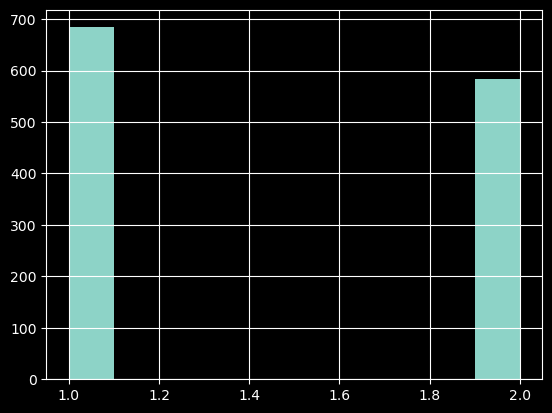

In [28]:
dataset.new_out.hist()

In [29]:
dataset.answer.unique()

array(['2', '1'], dtype=object)

In [30]:
# def change_target(x):
#     x = str(x)
#     if '1' in x: 
#         return 1
#     elif '2' in x:
#         return 2
#     else:
#         import numpy as np
#         return np.nan

<AxesSubplot:>

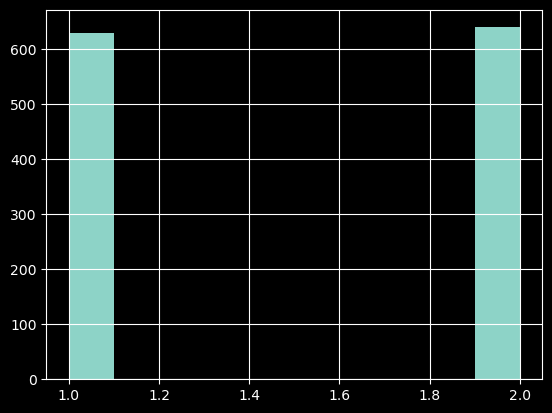

In [31]:
# dataset["new_target"] = dataset["target"].apply(change_target)
dataset["new_target"] = dataset["answer"].astype(int)
dataset["new_target"].hist()

### 8-bit

In [32]:
dataset["new_out"] = dataset["new_out"].fillna(-1)

In [33]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.584846093133386

In [34]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.5843217336633268

In [35]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.584846093133386

In [36]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.584193556903979

### Full

In [37]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.584846093133386

In [38]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.5843217336633268

In [39]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.584846093133386

In [40]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.584193556903979

In [41]:
dataset.to_csv("fiqa_ori.csv")